In [129]:
import numpy as np

import requests 
import json 
import pandas as pd 
import string 
import re 
import matplotlib.pyplot as plt 
import sklearn 
from sklearn.metrics import confusion_matrix , accuracy_score , f1_score
import pickle

# REDDIT DATA COLLECTION

#### I used PUSHSHIFT.IO API instead of PRAW as praw had certain limits on the number of data values. PRAW doesn't provide access to more than 1000 records

In [130]:
def getPushshiftData(sub=None, before=None, after=None, ids=None, getSubmissions=True, getComments=False):
    suffix=''
    searchType = 'submission'
    if getComments or not getSubmissions:
        searchType='comment'
    if (before is not None):
        suffix += '&before='+str(before)
    if (after is not None):
        suffix += '&after='+str(after)
    if (sub is not None):
        suffix += '&subreddit='+sub
    if (ids is not None):
        suffix += '&ids='+','.join(ids)

    url = 'https://api.pushshift.io/reddit/search/'+searchType+'?sort=desc&size=1500'+suffix
    r = requests.get(url)
    data = json.loads(r.content)
    if len(data['data']) > 0:
        prev_end_date = data['data'][-1]['created_utc']
    else:
        prev_end_date = None
    return (data, prev_end_date)

#### The time have been set to 120 days which results in collection of around 50000-60000 titles

In [131]:
sub='India'
(submissions_tmp, prev_end_date) = getPushshiftData(sub=sub, after='120d')
submissions = submissions_tmp['data']
while prev_end_date is not None:
    try:
        (submissions_tmp, prev_end_date) = getPushshiftData(sub=sub, before=prev_end_date-1, after='120d')
        if prev_end_date is not None:
            submissions.extend(submissions_tmp['data'])
    except:
        continue

In [132]:
submission =[]
for post in submissions:
    submission.append(post)

In [48]:
submission_df=pd.DataFrame(submission)

In [49]:
df1 = pd.concat([submission_df['title'],submission_df['link_flair_text']], axis = 1)

# Exploratory Data Analysis

In [50]:
df1 = df1.dropna()

In [51]:
pd.set_option('display.max_colwidth', 100)
df = df1.copy()
df['flair'] = df['link_flair_text']
df= df.drop(['link_flair_text'], axis = 1)
df

,title,flair
0,In lockdown prepping to make Baati Chokha,Food
1,1300 people sign online petition to disable WhatsApp on Amitabh Bachchan’s phone,Non-Political
2,1300 people sign online petition to disable WhatsApp on Amitabh Bachchan’s phone - here’s why - ...,Non-Political
3,"Aarogya Setu app revealed some user data to YouTube, defect fixed now",Science/Technology
4,"After Facebook-Reliance deal, JioMart goes live on WhatsApp",Business/Finance
...,...,...
58647,Owned it!,Politics
58648,Confusion,Politics
58649,Why is this space so anti-Modi/BJP?,AskIndia
58650,Can i become a good boxer by self learning?,AskIndia


In [52]:
flair_set = set(df['flair'])

In [53]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [54]:
df.groupby('flair').count()['title'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,
                                                           title='Bar chart of Department Name', xTitle='Department Name')

##### IT WAS FOUND THAT THE DATA WAS HIGHLY BIASED .
MORE THAN 50% DATA WAS COMPRISED OF JUST 4 CLASSES.
SEPERATED THE 10 MOST FREQUENT FLAIRS & ENLISTED THEM IN LIST CALLED FLAIR2KEEP .
ALL OTHER CLASSES WERE DROPPED AS IT WOULD BE DIFFICULT FOR THE MODEL TO WORK WITH SO MANY CLASSES

In [55]:
flairs2keep = df1['link_flair_text'].value_counts()[:10].index.tolist()
flairs2keep

['Politics',
 'Non-Political',
 'Coronavirus',
 'AskIndia',
 'Policy/Economy',
 'Science/Technology',
 'Business/Finance',
 'CAA-NRC',
 'Photography',
 'Food']

In [56]:
for f in flair_set:
    if f not in flairs2keep:
        df = df[df.flair != f]
    else :
        continue

In [57]:
set(df['flair'])

{'AskIndia',
 'Business/Finance',
 'CAA-NRC',
 'Coronavirus',
 'Food',
 'Non-Political',
 'Photography',
 'Policy/Economy',
 'Politics',
 'Science/Technology'}

### BALANCING THE BIASED DATA

##### It was observed that the data collected was biased. On analysing the number of count 

##### i found that the class with minimum count had 500(appx) values whereas the rest lower 5 varied from 1000-1500. I decided it would be fair enough to resample the data to a value of 2000 per class.

#####  2000 DATA VALUES FROM EACH CLASS WERE EXPLICILY TAKEN BY PERFORMING OVER OR UNDERSAMPLING ACCORDINGLY

In [58]:
flairs_count = {'flair' : [] , 'count' : []}
for flair in flairs2keep:
    count = np.sum(df.loc[:, 'flair'].values == flair)
    flairs_count['flair'].append(flair)
    flairs_count['count'].append(count)
pd.DataFrame(flairs_count)

,flair,count
0,Politics,10732
1,Non-Political,9321
2,Coronavirus,9089
3,AskIndia,6002
4,Policy/Economy,1686
5,Science/Technology,1617
6,Business/Finance,1526
7,CAA-NRC,1070
8,Photography,1022
9,Food,546


In [59]:
corona_df = df[df.flair == 'Coronavirus']
np_df     = df[df.flair == 'Non-Political']
p_df      = df[df.flair == 'Politics']
ask_df    = df[df.flair == 'AskIndia']
food_df   = df[df.flair == 'Food']
tech_df   = df[df.flair == 'Science/Technology']
econ_df   = df[df.flair == 'Policy/Economy']
fin_df    = df[df.flair == 'Business/Finance']
caa_df    = df[df.flair == 'CAA-NRC']
photo_df  = df[df.flair == 'Photography']

In [60]:
from sklearn.utils import resample

corona_bal = resample(corona_df,
                          replace = False, 
                          n_samples = 2000, 
                          random_state = 27)
np_bal = resample(np_df,
                          replace = False,
                          n_samples = 2000, 
                          random_state = 27)
p_bal = resample(p_df,
                          replace = False, 
                          n_samples = 2000, 
                          random_state = 27)
ask_bal = resample(ask_df,
                          replace = False, 
                          n_samples = 2000, 
                          random_state = 27)

photo_bal =  resample(photo_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
food_bal  =  resample(food_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
tech_bal  =  resample(tech_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
econ_bal = resample(econ_df,
                          replace = True,
                          n_samples = 2000, 
                          random_state = 27)
fin_bal = resample(fin_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
caa_bal = resample(caa_df,
                          replace = True, 
                          n_samples = 2000,
                          random_state = 27)



In [61]:
df_2 = pd.concat([caa_bal,econ_bal,fin_bal,tech_bal,food_bal,ask_bal,photo_bal,p_bal,np_bal,corona_bal ])

In [62]:
flairs_count = {'flair' : [] , 'count' : []}
for flair in flairs2keep:
    count = np.sum(df_2.loc[:, 'flair'].values == flair)
    flairs_count['flair'].append(flair)
    flairs_count['count'].append(count)
pd.DataFrame(flairs_count)

,flair,count
0,Politics,2000
1,Non-Political,2000
2,Coronavirus,2000
3,AskIndia,2000
4,Policy/Economy,2000
5,Science/Technology,2000
6,Business/Finance,2000
7,CAA-NRC,2000
8,Photography,2000
9,Food,2000


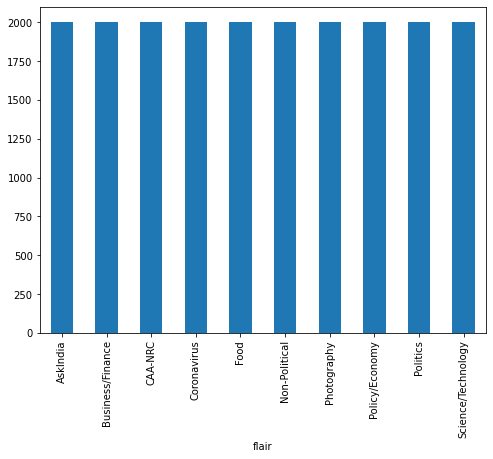

In [63]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_2.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

In [64]:
df_3 = df.copy()
df = df_2

In [92]:
set_flair = set(df['flair'])

## PREPROCESSING

#####  AS A PART OF PREPROCESSING
NUMBERS , PUNCTUATIONS , EMOJIS , STOPWORDS WERE REMOVED FROM THE TEXT.
LEMMATIZATION OF TEXT WAS DONE INSTEAD OF STEMMING. ALSO, TOKENIZATION OF DATA WAS ALSO DONE

I USED REGULAR EXPRESSIONS & NLTK LIBRARY TO PREPROCESS THE DATA

I prefered lemmatization over because stemmers reduce the word to its root form by removing the suffix and the result may or may not hold meaning whereas lemmatizatio resulted in meaniful root words.

I had to use these words to use glove embedding further in the process therefore the words had to meaningful moreove lemmatizers also keep track of synonyms therefore reducing the dimensionality

In [66]:
def no_num(text):
    text = re.sub('[0-9]+', '', text)
    return text

def no_punc(text):
    #nopuncmsg = ''.join([c for c in text if c not in string.punctuation])
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub(' +', ' ', text)
    return text

In [67]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

In [68]:
tokenized = []
def tokenizer(text):
    tokenized = word_tokenize(text)
    return tokenized
remov_stop_words = []
def remov_stopwords(text):
    remov_stop_words  =' '.join([c for c in text.split(' ') if c not in stopwords.words('english')])
    return remov_stop_words
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
def func_lemmatizer(text):
    lemmatized = []
    lemmatizer = WordNetLemmatizer()
    lemmatized = ' '.join( [ lemmatizer.lemmatize(word) for word in text] )
    return lemmatized

In [69]:
index_perm = np.random.permutation(df.index)

In [70]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(20)

,title,flair
0,"‘Tumse bade ho gye toh patak patak k marenge’, ab kaha gye liberals?",CAA-NRC
1,India likely to raise import duties on more than 50 items next week,Policy/Economy
2,"1st in 11 years: No. of passengers falls at IGI, Mumbai airports",Business/Finance
3,Ex-CJI Gogoi explains why he accepted RS nomination,AskIndia
4,"From NSO, NCRB to NPR and NCR, the Modi Government Has a Love-Hate Relationship With Data. If 20...",Politics
5,ICICI Bank has $100 million exposure to bankrupt Singapore oil trader,Policy/Economy
6,Vehicle insurance to cost 5% to 15% more from April 1,Policy/Economy
7,Will i pass,AskIndia
8,How perfectly these two headlines lined up to depict the current hypocrisy that’s overtaken us.,CAA-NRC
9,LPG price hiked by ₹144.5 per cylinder:,Politics


In [71]:
text = df['title']

In [72]:
def preprocessor(text):
    text = text.str.lower()
    text = text.apply(no_num)
    text = text.apply(no_punc)
    text = text.apply(remov_stopwords)
    text = text.apply(deEmojify)
    text = text.apply(tokenizer)
    text = text.apply(func_lemmatizer)
    return text

In [73]:
text = preprocessor(df['title'])
df['title'] = text
df

,title,flair
0,tumse bade ho gye toh patak patak k marenge ab kaha gye liberal,CAA-NRC
1,india likely raise import duty item next week,Policy/Economy
2,st year passenger fall igi mumbai airport,Business/Finance
3,ex cji gogoi explains accepted r nomination,AskIndia
4,nso ncrb npr ncr modi government love hate relationship data year data may year dangerous data,Politics
...,...,...
19995,fog new delhi,Photography
19996,bjp leader kailash vijayvargiya call labourer working house bangladeshi eating poha,Politics
19997,flysolo sale,Business/Finance
19998,roop durgapal whatsapp number phone number complete bio grotal com,Business/Finance


##### I MADE MY OWN DICTIONARY WHICH WAS FURTHER USED IN BUILDING LSTM LANGUAGE MODEL. THE MODEL SCRAPES THROUGH THE WHOLE TEXT AND ASSIGNS AN INDEX TO EACH UNIQUE WORD & ALSO MANTAING THE WORD COUNT

In [74]:
SOS_token = 0
EOS_token = 1
word2count = {}
word2index = {}
index2word = {}
n_words =  [0]

In [75]:
def addword(word , n_words , word2count , word2index , index2word ):
    if word not in word2index:
        word2index[word] = n_words[0]
        index2word[ n_words[0] ] = word
        word2count[word] = 1
        n_words[0] = n_words[0] + 1
    else:
        word2count[word] +=1

def addtext( sentence ,n_words , word2count , word2index , index2word ):
        for word in sentence.split(' '):
            addword(word , n_words , word2count , word2index , index2word )

In [76]:
df_1 = df.copy()
df_1['title'] = df_1['title'].apply( addtext , args = (n_words , word2count , word2index , index2word) )

In [77]:
len(word2index)

15542

#### SEPERATE DICTIONARY FOR FLAIRS

In [78]:
index2flair={}
flair2index ={}
for k , flair in enumerate(set(df['flair'])):
    index2flair[k] = flair
    flair2index[flair] = k

In [79]:
flair2index

{'CAA-NRC': 0,
 'Policy/Economy': 1,
 'Business/Finance': 2,
 'Coronavirus': 3,
 'Non-Political': 4,
 'AskIndia': 5,
 'Photography': 6,
 'Politics': 7,
 'Science/Technology': 8,
 'Food': 9}

## ML MODELS

In [80]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer , TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB , MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, linear_model, metrics

In [81]:
target_index = []
target_names = []

In [82]:
for flair in df['flair']:
    target_index.append(flair2index[str(flair)])
    target_names.append(flair)

In [83]:
corpus = []
for title in df['title']:
    corpus.append(title)

#### SPLITTING DATA FOR TESTING AND TRAINING . I TOOK ONLY 20% DATA AS TESTING DATA. AS I ALREADY HAD LESS DATA

In [84]:
train_x , test_x , train_y , test_y = train_test_split(corpus , target_names , test_size = 0.2)

### COUNTER VECTORIZER

IS A LIBRARY WHICH GIVES A DICTIONARY , VOCABULARY , WORD COUNTS OF THE CORPUS(INPUT) AS OUTPUT.

In [133]:
cv = CountVectorizer()
X = cv.fit(train_x)
#X.vocabulary
#X.get_feature_names()
counts = cv.transform(train_x)
print(counts.shape)
#counts.toarray()

(16000, 14257)


##### I USED PICKLE TO SAVE THE TRAINED MODEL & LOAD IT WHEN REQUIRED.

In [86]:
Pkl_Filename = "Pickle_CV_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(cv, file)

### TFIDF TRANSFORMER

ASSIGNS WEIGHTS TO THE WORDS ACCORDING TO THEIR FREQUENCY IN THE TEXT.
SO IF STOP WORDS LEFT WILL BE GIVEN THE MOST WEIGHTAGE

In [87]:
tf = TfidfTransformer()
X_tfidf = tf.fit_transform(counts)
print('learning frequency of all features :' + str(tf.idf_) + '\n\n')
freq = tf.transform(counts)
print(freq.toarray())

learning frequency of all features :[9.29411214 9.98725932 9.58179421 ... 9.98725932 9.58179421 9.58179421]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##### SAVING THE TFIDF MODEL ON PICKLE

In [88]:
Pkl_Filename = "Pickle_TF_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(tf, file)

#### I TRIED TO PREDICT WHICH MODEL WILL WORK BETTER ON THE FOLLOWING DATA

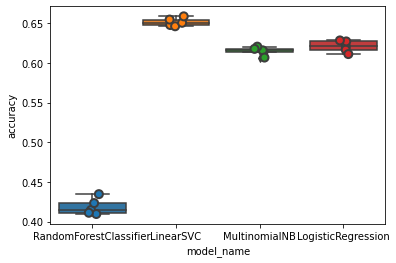

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0 , max_iter = 5000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_tfidf, train_y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [90]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.651313
LogisticRegression        0.620625
MultinomialNB             0.614750
RandomForestClassifier    0.418750
Name: accuracy, dtype: float64

### LOGISTIC REGRESSION

ASSGNS OBSERVATIONS FOR DISCRETE CLASSES .
IT IS BASED ON STATISTICAL APPROACHES & IS VULNERABLE TO OVERFITTING BECAUSE OF IT

In [93]:
lr = LogisticRegression(max_iter = 5000)
x_lr = lr.fit(X_tfidf, train_y)
x_test_tf = cv.transform(test_x)
x_test_tfidf = tf.transform(x_test_tf)
predicted = lr.predict(x_test_tfidf)
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

accuracy :  0.64825
                    precision    recall  f1-score   support

           CAA-NRC       0.43      0.40      0.41       396
    Policy/Economy       0.73      0.74      0.73       442
  Business/Finance       0.79      0.81      0.80       430
       Coronavirus       0.57      0.62      0.59       368
     Non-Political       0.87      0.90      0.88       389
          AskIndia       0.35      0.28      0.31       421
       Photography       0.77      0.87      0.82       389
          Politics       0.65      0.67      0.66       390
Science/Technology       0.55      0.48      0.51       392
              Food       0.68      0.71      0.69       383

          accuracy                           0.65      4000
         macro avg       0.64      0.65      0.64      4000
      weighted avg       0.64      0.65      0.64      4000



array([[159,  32,  13,  32,  11,  54,  18,  21,  28,  28],
       [ 21, 327,   1,  13,   2,  16,   3,  30,   5,  24],
       [  8,   3, 348,   4,   5,  14,   3,   3,  34,   8],
       [ 31,   3,   3, 227,  12,  35,   9,  15,  15,  18],
       [ 10,   5,   0,   3, 350,   8,   5,   1,   3,   4],
       [ 74,  17,  15,  55,  12, 118,  34,  28,  44,  24],
       [  7,   8,   0,   8,   2,  17, 338,   2,   3,   4],
       [ 14,  33,  11,  16,   3,  10,   7, 263,  22,  11],
       [ 26,   7,  50,  23,   5,  43,  10,  29, 190,   9],
       [ 24,  16,   2,  18,   1,  24,  10,  12,   3, 273]])

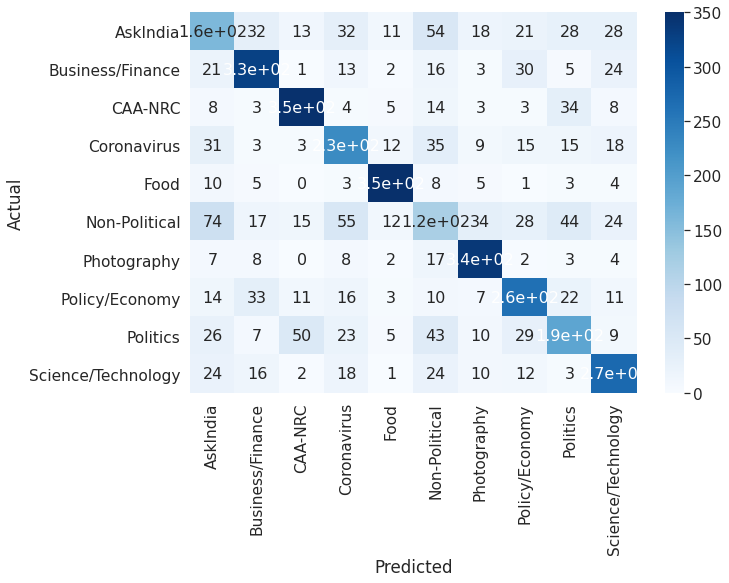

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np



data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

###  MULTINOMIAL NAIVE BAYES

I STARTED WITH NAIVE BAYES AS BASE MODEL FOR CLASSIFICATION. 
NAIVE BAYES IS A PROBABILISTIC APPROACH AND CONSIDERS EVERY FEATURE INDEPENDENT OF THE OTHER. 

In [95]:
clf = MultinomialNB().fit(X_tfidf,train_y)

In [96]:
Pkl_Filename = "Pickle_NB_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

In [97]:
set_flair = []
for f in set(test_y):
    set_flair.append(f)

In [98]:
x_test_tf = cv.transform(test_x)
x_test_tfidf = tf.transform(x_test_tf)
predicted = clf.predict(x_test_tfidf)

In [99]:
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

accuracy :  0.625
                    precision    recall  f1-score   support

              Food       0.43      0.35      0.38       396
    Policy/Economy       0.71      0.68      0.69       442
           CAA-NRC       0.67      0.86      0.75       430
  Business/Finance       0.48      0.66      0.56       368
       Coronavirus       0.82      0.90      0.86       389
     Non-Political       0.36      0.14      0.20       421
          AskIndia       0.76      0.85      0.80       389
          Politics       0.58      0.68      0.63       390
Science/Technology       0.55      0.44      0.49       392
       Photography       0.67      0.69      0.68       383

          accuracy                           0.62      4000
         macro avg       0.60      0.63      0.61      4000
      weighted avg       0.60      0.62      0.60      4000



array([[138,  33,  26,  41,  15,  29,  20,  28,  30,  36],
       [ 13, 299,   3,  19,   5,   9,   8,  52,   5,  29],
       [  5,   3, 370,   7,   5,   3,   3,   3,  25,   6],
       [ 26,   3,  12, 244,  12,  16,   7,  22,  11,  15],
       [ 12,   6,   2,   3, 352,   3,   6,   1,   1,   3],
       [ 64,  17,  33,  87,  19,  58,  40,  36,  45,  22],
       [ 10,   8,   6,  10,   6,   9, 332,   2,   3,   3],
       [ 17,  28,  18,  19,   5,   3,   4, 267,  18,  11],
       [ 19,   3,  78,  39,   5,  22,   9,  34, 174,   9],
       [ 19,  20,   5,  35,   3,   8,   9,  15,   3, 266]])

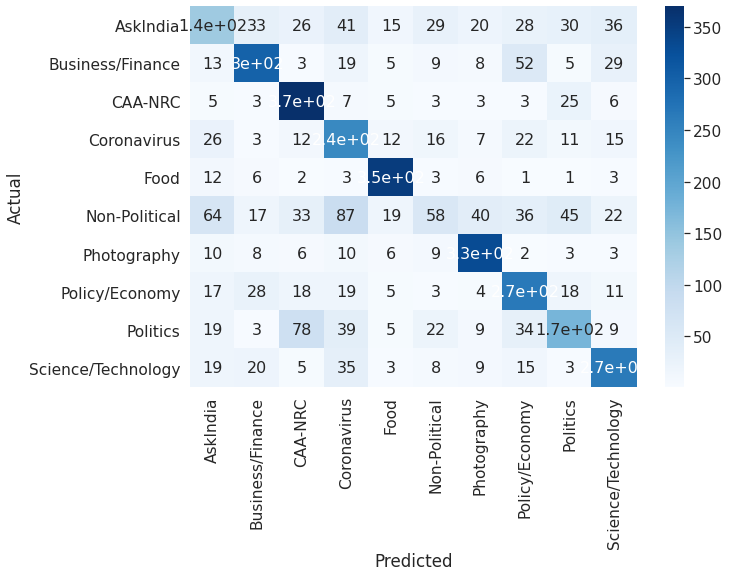

In [100]:
data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

### Linear SVM

SUPPORT VECTOR MACHINE IS A GEOMETRIC APPROACH AND CONSIDERS ALL FEATURES DEPENDENT TO EACH OTHER. HENCE , IT CONSIDERS THE RELATION BETWEEN DIFFERENT FEATURES & HENCE IMPROVING THE RESULT

In [101]:
lsvm = LinearSVC().fit(X_tfidf, train_y)

In [102]:
x_test_tf = cv.transform(test_x)
x_test_tfidf = tf.transform(x_test_tf)
predicted = lsvm.predict(x_test_tfidf)

In [103]:
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

accuracy :  0.669
                    precision    recall  f1-score   support

              Food       0.45      0.35      0.40       396
    Policy/Economy       0.77      0.81      0.79       442
           CAA-NRC       0.78      0.89      0.83       430
  Business/Finance       0.52      0.54      0.53       368
       Coronavirus       0.88      0.96      0.92       389
     Non-Political       0.35      0.25      0.29       421
          AskIndia       0.81      0.91      0.86       389
          Politics       0.69      0.75      0.72       390
Science/Technology       0.53      0.46      0.49       392
       Photography       0.68      0.77      0.72       383

          accuracy                           0.67      4000
         macro avg       0.65      0.67      0.65      4000
      weighted avg       0.65      0.67      0.66      4000



array([[140,  32,  14,  42,  10,  57,  16,  19,  36,  30],
       [ 10, 356,   3,   7,   1,  12,   4,  28,   4,  17],
       [  7,   2, 382,   1,   5,   6,   0,   2,  20,   5],
       [ 29,   6,   9, 198,  12,  39,   8,  18,  24,  25],
       [  3,   5,   0,   0, 374,   2,   3,   0,   1,   1],
       [ 60,  17,  21,  61,  13, 106,  26,  28,  58,  31],
       [  5,   2,   1,   5,   1,  15, 354,   2,   1,   3],
       [ 17,  19,   8,  12,   0,  12,   4, 292,  14,  12],
       [ 24,   6,  47,  39,   6,  37,  12,  27, 181,  13],
       [ 15,  18,   3,  14,   2,  20,   8,   7,   3, 293]])

In [104]:
Pkl_Filename = "Pickle_SVM_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(lsvm, file)

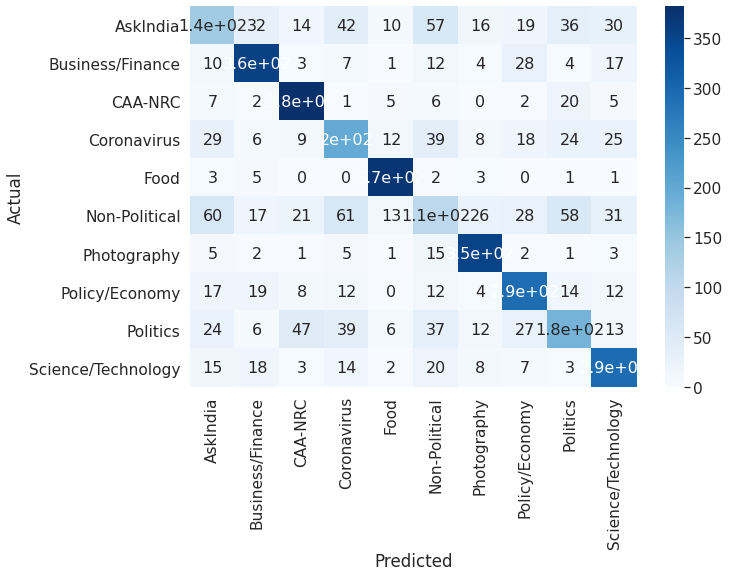

In [105]:
data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

### RANDOM FOREST MODEL

FOR EXPLAINABILITY AS RFC MODELS MEASURE THE WEIGHTAGE OF EACH WORD FOR EACH CLASS .  THEREFORE , ACCURACY OF THIS MODEL IS MANY TIMES BETTER.

In [106]:
cv = CountVectorizer()
rfc_x = cv.fit_transform(train_x)
rfc= RandomForestClassifier()
rfc.fit(rfc_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [107]:
x_test_tf = cv.transform(test_x)
predicted = rfc.predict(x_test_tf)
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

accuracy :  0.66275
                    precision    recall  f1-score   support

              Food       0.37      0.31      0.34       396
    Policy/Economy       0.75      0.83      0.79       442
           CAA-NRC       0.72      0.90      0.80       430
  Business/Finance       0.53      0.61      0.56       368
       Coronavirus       0.87      0.97      0.92       389
     Non-Political       0.30      0.21      0.25       421
          AskIndia       0.76      0.92      0.83       389
          Politics       0.74      0.73      0.73       390
Science/Technology       0.59      0.39      0.47       392
       Photography       0.76      0.77      0.76       383

          accuracy                           0.66      4000
         macro avg       0.64      0.66      0.64      4000
      weighted avg       0.64      0.66      0.64      4000



array([[122,  43,  30,  39,   9,  67,  17,  14,  20,  35],
       [ 12, 366,   5,   9,   1,  10,   4,  22,   4,   9],
       [ 10,   2, 388,   4,   0,   6,   4,   1,  11,   4],
       [ 38,   7,   9, 223,  13,  35,  11,  11,  16,   5],
       [  5,   5,   0,   1, 376,   1,   0,   0,   0,   1],
       [ 74,  23,  27,  71,  12,  89,  44,  26,  35,  20],
       [  3,   2,   3,   1,   4,  15, 358,   1,   0,   2],
       [ 13,  23,  11,  21,   2,   7,   7, 283,  12,  11],
       [ 33,   7,  59,  43,   9,  44,  18,  21, 151,   7],
       [ 16,  12,   6,  11,   4,  19,  10,   5,   5, 295]])

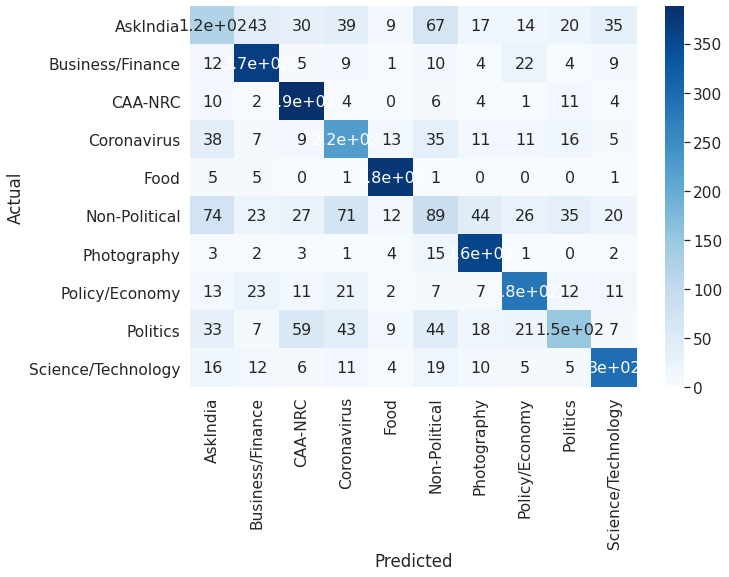

In [108]:
data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

In [109]:
Pkl_Filename = "Pickle_RFC_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(rfc, file)

####  I WILL BE USING NAIVE BAYES , LINEAR SVM , RANDOM FOREST FOR PREDICTING THE OUTPUT IN THE FINAL MODEL

#### I BUILT A HYBRID MODEL WHERE I CONSIDER THE PROBABILITY OF OUTPUT OF EACH MODEL & THE MODEL, WITH MOST PROBABILITY OR THE MODEL WHICH IS MOST CONFIDENT ABOUT THE OUTPUT . ONLY THAT MODEL'S OUPUT WOULD BE RETURED.

# LSTM LANGUAGE MODEL

#####  INSTEAD OF MAKING MY OWN EMBEDDINGS .
##### I PREFERED USING GLOVE EMBEDDINGS DEVELOPED BY STANFORD NLP WHICH WAS TRAINED ON MILLIONS OF DATA WHICH ENSURED A BETTER EMBEDDING.

In [110]:
file = "/home/aaryan/Documents/Research/ELMO 1/glove.6B.50d.txt"
import numpy as np
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    
     
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
     
     
model= loadGloveModel(file)   
 
print (model['hello'])

Loading Glove Model
Done. 400000  words loaded!
[-0.38497   0.80092   0.064106 -0.28355  -0.026759 -0.34532  -0.64253
 -0.11729  -0.33257   0.55243  -0.087813  0.9035    0.47102   0.56657
  0.6985   -0.35229  -0.86542   0.90573   0.03576  -0.071705 -0.12327
  0.54923   0.47005   0.35572   1.2611   -0.67581  -0.94983   0.68666
  0.3871   -1.3492    0.63512   0.46416  -0.48814   0.83827  -0.9246
 -0.33722   0.53741  -1.0616   -0.081403 -0.67111   0.30923  -0.3923
 -0.55002  -0.68827   0.58049  -0.11626   0.013139 -0.57654   0.048833
  0.67204 ]


In [111]:
import csv 
words = pd.read_table(file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
def vec(w):
    return words.loc[w].to_numpy()

 
print (vec('hello')) 

[-0.38497   0.80092   0.064106 -0.28355  -0.026759 -0.34532  -0.64253
 -0.11729  -0.33257   0.55243  -0.087813  0.9035    0.47102   0.56657
  0.6985   -0.35229  -0.86542   0.90573   0.03576  -0.071705 -0.12327
  0.54923   0.47005   0.35572   1.2611   -0.67581  -0.94983   0.68666
  0.3871   -1.3492    0.63512   0.46416  -0.48814   0.83827  -0.9246
 -0.33722   0.53741  -1.0616   -0.081403 -0.67111   0.30923  -0.3923
 -0.55002  -0.68827   0.58049  -0.11626   0.013139 -0.57654   0.048833
  0.67204 ]


In [112]:
#word_matrix = word.tonumpy()

##### TO BE USED GLOVE EMBEDDING FIRST HAS TO BE CONVERTED IN A FORM OF MATRIX :GLOVE WEIGHT MATRIX . WORD EMBEDDINGS OF EACH WORD IS SAVED IN THE MATRIX ACCORDING TO THEIR INDEXES IN THE DICTIONARY

In [113]:
matrix_len = len(word2index)
weights_matrix = np.zeros((matrix_len , 50))
words_found = 0

for i , word in enumerate(word2index):
    try:
        weights_matrix[i] = words.loc[str(word)] 
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6 , size = (weights_matrix.shape[1], ))

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [115]:
num_cases = df.shape[0]
num_cases

20000

#### STANDARD DATASET OF TEXT WITH LISTS ENLISTED WITH INDEXES OF OCCURING WORDS & SIMILAR LIST FOR FLAIRS.

In [116]:
x_dataset = np.zeros((num_cases , 10) , dtype = int)
y_dataset = np.zeros((num_cases), dtype = int)

for i , sentence in enumerate((df['title'])):
    for j , word in enumerate(sentence.split(' ')):
        if j < 10:
            x_dataset[i,j] = word2index[str(word)]
        else :
            break
    
for k, flair in enumerate(df['flair']):
    y_dataset[k] = flair2index[str(flair)]      
    

In [117]:
x_dataset = torch.tensor(x_dataset)
y_dataset = torch.tensor(y_dataset)

In [118]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size = 0.2, random_state = 0)

In [119]:
VOCAB_SIZE = weights_matrix.shape[0]
EMBEDDING_DIM = weights_matrix.shape[1]
HIDDEN_LAYER = 20

##### A LSTM LANGUAGE MODEL  BUILT IN PYTORCH FRAMEWORK . 
THE PRETRAINED GLOVE EMBEDDING WERE PASSED INTO THE MODEL IN THE FORM OF WEIGHT_MATRIX OR GLOVE WEIGHTS.
I HAD SOME PRE KNOWLEDGE THAT LSTM LANGUAGE MODELS WORKS BETTER ON TEXT AS COMPARED TO ML MODELS.
I USED RELU , SOFTMAX AS THE ACTIVATION LAYERS.

In [120]:
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False #eze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim ,10)
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.35)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        output = self.linear(ht[-1])
        output = self.relu(output)
        output = self.linear1(output)
        output = self.softmax(output)
        
        return output

##### I USED ADAM OPTIMIZER TO BACK PROPOGATE & OPTIMIZE MY MODEL. I PREFERED ADAM BECAUSE IT IS MORE SENSETIVE TOWARDS THE HYPER PARAMETERS COMPARED TO SGD OPTIMIZERS. THE VALUES OF HYPERMATERS AFFECT OUR MODEL A LOT AS A LOT OF PROCESSING NEEDS TO BE DONE .

In [121]:
model = LSTM_glove_vecs(VOCAB_SIZE , EMBEDDING_DIM , HIDDEN_LAYER , weights_matrix)
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [122]:
x_train = torch.tensor(x_train)

/home/aaryan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [123]:
softmax_prob = model(x_train)

/home/aaryan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Cross Entropy loss minimizes the distance between the probability distributions therefore it is prefered for classification problems.

In [124]:
loss_function = torch.nn.CrossEntropyLoss()
total_loss = 0
losses =[]
epochs = 1
print_every = 1000

### TRAINING

##### THE MODEL TRAINS A BATCH OF VALUES AT A TIME. IN THIS SPECIFIC CASE , THE SIZE OF BATCH IS DECIDED AS 100

In [125]:
i = 0
x_train_data = np.zeros((100,50), dtype = int)
y_train_data = np.zeros(100,dtype = int)
for epoch in range(epochs):
    for i in range(x_train.shape[0]):
        y_train_data = y_train[i:i+100 ]
        x_train_data = x_train[i:i+100, :]
        i= i+100
        model.zero_grad()
        y_pred = model(x_train_data)
        loss = loss_function(y_pred, y_train_data)
        loss.backward()
        optimizer.step()
        total_loss =+ loss.item()
        if i% print_every == 0:
            print(str(loss.item()) + ' for ' + str(i))

/home/aaryan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



2.3411343097686768 for 1000
2.4011542797088623 for 2000
2.2911510467529297 for 3000
2.3311314582824707 for 4000
2.2911510467529297 for 5000
2.3511509895324707 for 6000
2.391150951385498 for 7000
2.3511509895324707 for 8000
2.3211510181427 for 9000
2.271151065826416 for 10000
2.3711509704589844 for 11000
2.391150951385498 for 12000
2.381150960922241 for 13000
2.331151008605957 for 14000
2.391150951385498 for 15000
2.3111510276794434 for 16000


##### THE LOSS RATES DIDN'T IMPROVE MUCH
THE POSSIBLE REASONS CAN BE THE SHORTAGE OF DATA.
THERE MAY BE AN ISSUE WITH PARAMETERS.
I TRIED BOTH APPLYING GRADIENTS ON THE EMBEDDINGS AND FREEZING THEM BUT THE RESULTS WERE NOT SATISFACTORY.

#### ACCURACY OF THE MODEL

In [126]:
i = 0
accuracies = list()
x_test_data = np.zeros((100,50), dtype = int)
y_test_data = np.zeros(100,dtype = int)

for i in range(x_test.shape[0]):
    x_test_data = x_test[i:i+100,:]
    y_test_data = y_test[i:i+100]

    i = i + 100

    predictions, actuals,  = list(), list() 
    y_pred = model(x_test_data)
    y_pred = y_pred.detach().numpy()
    actual = y_test_data.numpy()
    y_pred = y_pred.round()
    predictions.append(y_pred)
    actuals.append(actual)
    predictions = np.array(predictions)

    actuals = np.array(actuals)
    b = np.zeros((actuals.size , 10))
    b[np.arange(actuals.size),actuals] = 1

    predictions_, actuals_ = np.vstack(predictions), np.vstack(b)
    acc = accuracy_score(actuals_, predictions_)
    acc=acc.astype(float)
    accuracies.append(acc)
    
    if i % 500 == 0:
        print(str(acc) + ' for ' + str(i))

/home/aaryan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



0.09 for 500
0.11 for 1000
0.08 for 1500
0.09 for 2000
0.07 for 2500
0.08 for 3000
0.16 for 3500
0.11 for 4000


In [127]:
accuracies = np.array(accuracies)

In [128]:
accuracies.mean()

0.09476947270735428

##### THE ACCURACY OF THE LSTM LANGUAGE MODEL WAS FOUND TO BE REALLY LOW.
AT LATER STAGES I REALISED THAT MY DATA WAS BIASED AND IT COULD BE A POSSIBLE REASON FOR THIS BUT IT DIDN'T IMPROVE EVEN AFTER BALANCING IT.
I ANALYSED IT AGAIN. I THOUGHT OF TWEAKING THE MODEL BY CHANGING THE OPTIMIZERS , LOSS FUNTIONS , SIZE OF HIDDEN LAYERS , BATCH SIZE , EPOCHS , LRs & EVEN DROPOUT RATES BUT I COULDN'T SEE MUCH DIFFERENCE IN THE RESULTS.
I BELIEVE THAT THE SIZE OF MY DATA WAS REALLY LOW COMPARED TO THE REQUIREMENTS AS SUCH NLP MODELS REQUIRE A LOTS OF TUNING .
ALSO ,A WILD GUESS CAN BE THAT I DID SOME ERROR WHILE USING GLOVE EMBEDDINGS.